# Create and run a Machine Learning model as a custom-script

This notebook showcases how to create a Machine Learning (ML) custom-script for water detection. 

The workflow uses [eo-learn](https://eo-learn.readthedocs.io/en/latest/) to process the data and [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a ML model for water classification given Seninel-2 band and index values. The resulting custom-script can be used in [the Sentinel Hub EOBrowser](https://www-test.sentinel-hub.com/explore/eobrowser/), in the [multi-temporal instance of Sentinel Playground](https://apps.sentinel-hub.com/sentinel-playground-temporal/?source=S2&lat=40.4&lng=-3.730000000000018&zoom=12&preset=1-NATURAL-COLOR&layers=B04,B03,B02&maxcc=20&gain=1.0&temporal=true&gamma=1.0&time=2015-01-01%7C2019-10-02&atmFilter=&showDates=false) and as evalscript in the [Sentinel Hub process API](https://docs.sentinel-hub.com/api/latest/api/process/).

The workflow is organised as follows:

 * [Data download](#Data-download)
 * [Features preparation](#Features-preparationn)
 * [Create train and test sets](#Create-train-and-test-sets)
 * [Train and evaluate model](#Train-and-evaluate-model)
 * [Convert model to evalscript](#Convert-model-to-evalscript)
 * [Test evalscript](#Test-evalscript)
 * [Possible improvements](#Possible-improvements)

In [1]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import urllib.request
import shutil
import zipfile

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Machine learning 
from sklearn.cluster import DBSCAN
import lightgbm as lgbm
from lightgbm import Booster
import joblib
from sklearn import metrics

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.geometry import PointSamplingTask 
from sentinelhub import SHConfig

# Local imports for utility functions
from utils import parse_model, visualize, predict_on_sh, get_predictions, plot_comparison

#### Constants

In [2]:
S2_BANDS = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
S2_BANDS_STR = ','.join(S2_BANDS)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_RATIO = .8

N_WORKERS = 4

N_SAMPLES = 100
REF_LABELS = [0, 1]  

## Data download

The dataset used in this notebook is openly available on [queryplanet.sentinel-hub.com](http://queryplanet.sentinel-hub.com/index.html), and has been crowd-sourced through a labelling campaign on [ClassificationApp](https://apps.sentinel-hub.com/classificationApp/#/campaigns/2d89a0ae774111e98ffbb97eadc8b396).

The aim of the campaign is to collect labels for water detection using Sentinel-2 bands. The water detection algorithm can be used to improve the current algorithm employed in the [BlueDot Observatory](https://water.blue-dot-observatory.com).

The dataset contains **7671** `EOPatch`es. Each `EOPatch` contains all 13 Sentinel-2 L1C of size `64x64` pixels, as well as the Mapzen Digital Elevation Model. In addition, where applicable, `EOPatch`es contain Sentinel-1 acquisitions having the closest date to the Sentinel-2 acquisition. The Sentinel-2 timestamp and bounding box are as well stored in the `meta_info` of the `EOPatch`.

An overview of the dataset content is available in the `data-info.geojson` file, as shown below.

In [3]:
DATA_URL = 'http://queryplanet.sentinel-hub.com/water-labels'

DATA_INFO = f'{DATA_URL}/data-info.geojson'
EOP_URL = f'{DATA_URL}/eopatches.zip'

# Modify these paths to your local environment
EOP_ZIP = './eopatches.zip'
EOP_DIR = '.'

In [4]:
gdf = gpd.read_file(DATA_INFO)

In [5]:
gdf.head()

,has_DEM,has_S1_ASC,has_S1_DES,has_S2,task_id,timestamp,window_height,window_width,geometry
0,1,0,0,1,6b73fd74a2eb11e994fbf0db728b8d14,2016-09-26,64,64,"POLYGON ((65.84065 52.68916, 65.84065 52.69491..."
1,1,0,1,1,0a27f4aea2eb11e9bfdaa9140581204c,2017-08-12,64,64,"POLYGON ((64.47018 50.95125, 64.47018 50.95701..."
2,1,1,1,1,9b60193ea24111e98d7d929084d604de,2019-03-23,64,64,"POLYGON ((31.15408 38.61106, 31.15408 38.61600..."
3,1,1,1,1,9afaabaea24111e983d185262381d01a,2018-05-31,64,64,"POLYGON ((-1.60285 38.21084, -1.60285 38.21558..."
4,1,0,1,1,9dfb5254a24111e9a087737fe71fcff1,2018-05-27,64,64,"POLYGON ((48.22342 48.99523, 48.22342 49.00099..."


In [6]:
len(gdf[gdf.has_S2==1]), len(gdf[gdf.has_DEM==1]), len(gdf[gdf.has_S1_ASC==1]), len(gdf[gdf.has_S1_DES==1])

(7671, 7671, 3221, 5134)

### Download and unzip file with eopatches

This code downloads and unzips the file containing the `EOPatches`. 

In [7]:
print(f'Downloading {EOP_URL} to {EOP_ZIP} ..')
with urllib.request.urlopen(EOP_URL) as response, open(EOP_ZIP, 'wb') as zip_file:
    shutil.copyfileobj(response, zip_file)
    
print(f'Unzipping {EOP_ZIP} to {EOP_DIR} ..')
with zipfile.ZipFile(EOP_ZIP, 'r') as zip_file:
    zip_file.extractall(EOP_DIR)

Unzipping ./eopatches.zip to . ..


Check that all `EOPatches` have been downloaded and unzipped.

In [8]:
ls {EOP_DIR}/eopatches | wc -l 

7671


## Features preparation

This Section pre-processes the dataset into a ML-ready format using `eo-learn`. 

The workflow is as follows:
 * load eopatches
 * extract B02, B03 and B04 from all S2 bands
 * compute the Normalized Difference Water Index (NDWI)
 * compute the Normalized Difference Moisture Index (NDMI)
 * concatenate the features as [B02, B03, B04, NDWI, NDMI]
 * randomly sample pixels from features and labels
 * add the newly created features and sampled features to `EOPatches`
 
The workflow is then parallelized over the eopatches for faster execution.

In [9]:
# Build name of eopatches, given by index of `data_info`
eopatch_names = [f'eopatch-{idx:04d}' for idx in np.arange(len(gdf))]

Load an `EOPatch` and inspect content

In [10]:
eop = EOPatch.load(f'{EOP_DIR}/eopatches/{eopatch_names[1]}')
eop

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(1, 64, 64, 13), dtype=float32)
    TRUE-COLOR-S1-IW-DES: numpy.ndarray(shape=(1, 64, 64, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 64, 64, 1), dtype=bool)
    IS_DATA_S1_IW_DES: numpy.ndarray(shape=(1, 64, 64, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(64, 64, 1), dtype=float32)
  }
  mask_timeless: {
    water_label: numpy.ndarray(shape=(64, 64, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    TRUE-COLOR-S1-IW-DES: datetime.timedelta(-2, 6658)
    maxcc: 1.0
    service_type: 'wms'
    size_x: 64
    size_y: 64
    time_difference: datetime.timedelta(1)
    time_interval: (datetime.datetime(2017, 8, 12, 0, 0), datetime.datetime(2017, 8, 13, 0, 0))
    timestamp: '2017-08-12'
  }
  bbox: BBox(((64.47018117599022, 50.951253746594006), (64.47931440474328, 50.9570068827248)), crs=CRS('4

---
Let's have a look at data first

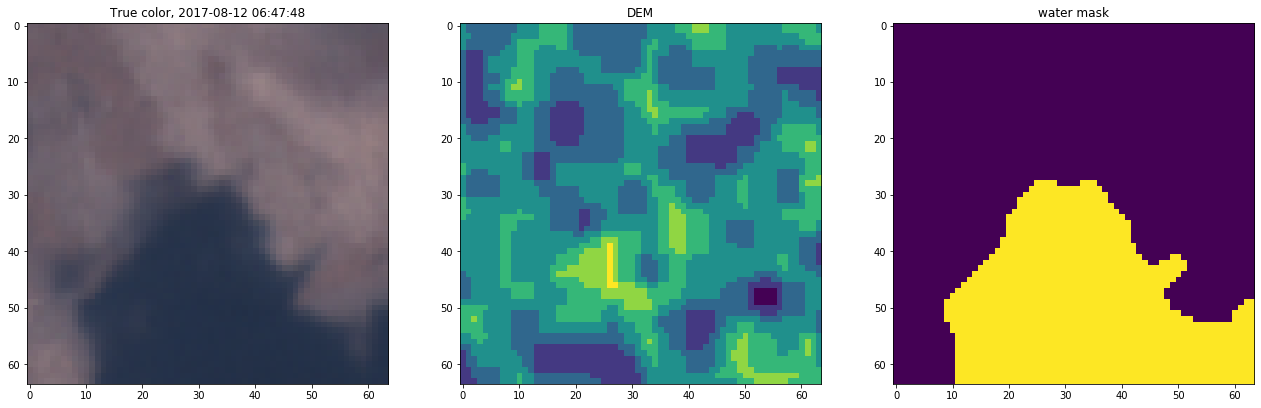

In [11]:
visualize(eop)

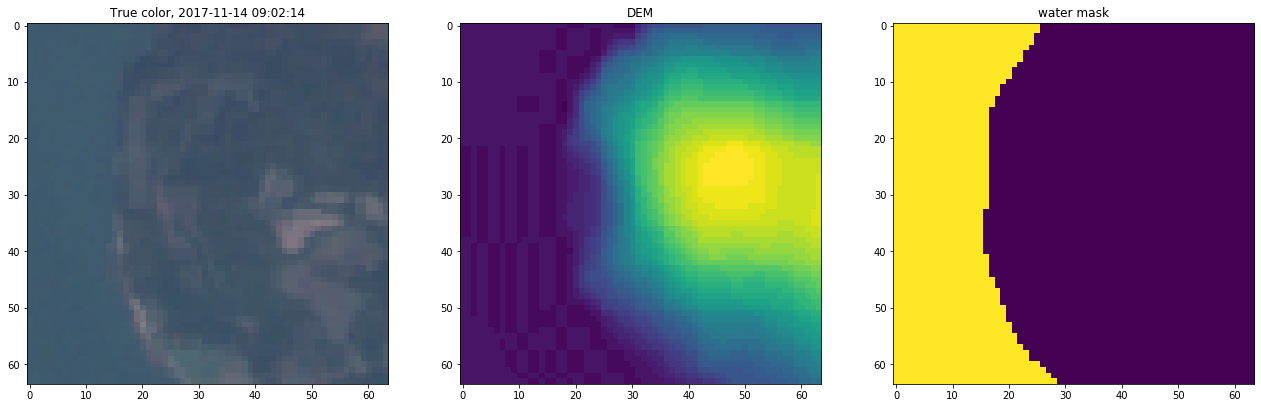

In [12]:
visualize(EOPatch.load(f'{EOP_DIR}/eopatches/{eopatch_names[132]}', lazy_loading=True))

---

In [13]:
# Set up names of EOPatch features for convenience
BANDS_FEATURE = FeatureType.DATA, 'BANDS-S2-L1C'
IS_DATA_FEATURE = FeatureType.MASK, 'IS_DATA'

BANDS_SUB_FEATURE = FeatureType.DATA, 'BANDS-SUBSET'
NDWI_FEATURE = FeatureType.DATA, 'NDWI'
NDMI_FEATURE = FeatureType.DATA, 'NDMI'

FEATURES = FeatureType.DATA, 'FEATURES'

LABELS = FeatureType.MASK_TIMELESS, 'water_label'

FEATURES_SAMPLED = FeatureType.DATA, 'FEATURES_SAMPLED'
IS_DATA_SAMPLED = FeatureType.MASK, 'IS_DATA_SAMPLED'
LABELS_SAMPLED = FeatureType.MASK_TIMELESS, 'water_label_SAMPLED'

Initialise the `EOTask`s defining the workflow

In [14]:
# Load eopatch
load_task = LoadTask(f'{EOP_DIR}/eopatches/')

# Keep only B02, B03, B04
extract_task = ExtractBandsTask(input_feature=BANDS_FEATURE, 
                                output_feature=BANDS_SUB_FEATURE, 
                                bands=[S2_BANDS.index(s2b) for s2b in ['B02', 'B03', 'B04']])

# NDWI = (B03 - B08) / (B03 + B08)
ndwi_task = NormalizedDifferenceIndexTask(input_feature=BANDS_FEATURE,
                                          output_feature=NDWI_FEATURE,
                                          bands=[S2_BANDS.index(s2b) for s2b in ['B03', 'B08']])

# NDMI = (B08 - B11) / (B08 + B11)
ndmi_task = NormalizedDifferenceIndexTask(input_feature=BANDS_FEATURE,
                                          output_feature=NDMI_FEATURE,
                                          bands=[S2_BANDS.index(s2b) for s2b in ['B08', 'B11']])

# Merge features as [B02, B03, B04, NDWI, NDMI]
merge_task = MergeFeatureTask(input_features=[BANDS_SUB_FEATURE, NDWI_FEATURE, NDMI_FEATURE],
                              output_feature=FEATURES)

# Task for pixels' sampling
sampling_task = PointSamplingTask(
    n_samples=N_SAMPLES, 
    ref_mask_feature=LABELS[1], 
    ref_labels=REF_LABELS, 
    sample_features=[  # tag fields to sample
        FEATURES,
        IS_DATA_FEATURE,
        LABELS
    ])

# Add to exising EOPatch only the sampled features and labels
save_task = SaveTask(
    f'{EOP_DIR}/eopatches/', 
    features=[FEATURES, FEATURES_SAMPLED, IS_DATA_SAMPLED, LABELS_SAMPLED],
    overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [15]:
# Define the workflow
workflow = LinearWorkflow(
    load_task,
    extract_task,
    ndwi_task,
    ndmi_task,
    merge_task,
    sampling_task,
    save_task
)

Execute the workflow in parallel by providing the `execution_args` that include the `on-the-fly` input arguments to the tasks.

In [16]:
%%time

# Create list of arguments to be passed at run-time
execution_args = []
for idx, eop_name in enumerate(eopatch_names):
    execution_args.append({
        load_task: {'eopatch_folder': eop_name},
        sampling_task: {'seed': idx},
        save_task: {'eopatch_folder': eop_name}
    })
    
# Execute workflow in parallel, e.g. each EOPatch is process in parallel in dedicated processes
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=N_WORKERS, multiprocess=True)

# Make report to check possible failures
executor.make_report()


CPU times: user 1min 56s, sys: 3.32 s, total: 1min 59s
Wall time: 4min 14s


Let's inspect the same `EOPatch` to check the newly added arrays

In [17]:
eop = EOPatch.load(f'{EOP_DIR}/eopatches/{eopatch_names[1]}')
eop

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(1, 64, 64, 13), dtype=float32)
    FEATURES: numpy.ndarray(shape=(1, 64, 64, 5), dtype=float32)
    FEATURES_SAMPLED: numpy.ndarray(shape=(1, 100, 1, 5), dtype=float32)
    TRUE-COLOR-S1-IW-DES: numpy.ndarray(shape=(1, 64, 64, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 64, 64, 1), dtype=bool)
    IS_DATA_S1_IW_DES: numpy.ndarray(shape=(1, 64, 64, 1), dtype=bool)
    IS_DATA_SAMPLED: numpy.ndarray(shape=(1, 100, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(64, 64, 1), dtype=float32)
  }
  mask_timeless: {
    water_label: numpy.ndarray(shape=(64, 64, 1), dtype=uint8)
    water_label_SAMPLED: numpy.ndarray(shape=(100, 1, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    TRUE-COLOR-S1-IW-DES: datetime.timedelta(-2, 6658)
    maxcc: 1.0
    service_type: 'wms'
    size_x: 64
    size_y: 6

## Create train and test sets

This section splits the data into a training and a testing set. For optimisation of the model, the training data should be further split to create a cross-validation set, to avoid over-fitting to the test data. 

The data contained in the `EOPatch`es can belong to the same water-body imaged during the same acquisition time. For this reason, the dataset should be grouped by location and by timestamp, such that data belonging to the same water-body and acquisition time do not end up in different train/test sets.

This grouping is here performed first geographically using the centroids of the `BBox`es, and then a further grouping is applied to the timestamps to obtain unique location/timestamp pairs.

In [18]:
gdf['x']=gdf.geometry.apply(lambda g: g.centroid.x)
gdf['y']=gdf.geometry.apply(lambda g: g.centroid.y)

db = DBSCAN(eps=0.1, 
            min_samples=1, 
            algorithm='ball_tree', 
            metric='euclidean').fit(gdf[['x', 'y']].to_numpy())

# Group by centroid coordinates
for label in set(db.labels_):
    class_member_mask = (db.labels_ == label)
    gdf.loc[class_member_mask,'cluster_id'] = label
    
# Further group by timestamp
gdf['group'] = gdf.groupby(by=['cluster_id','timestamp'],as_index=False).ngroup()
gdf.drop(columns=['x','y','cluster_id'], inplace=True)

# Randomly assign resulting groups to either train or test set
train_ids = set(np.where(np.random.rand(gdf.group.nunique())<=TRAIN_RATIO)[0])
gdf['isin_train'] = gdf.group.isin(train_ids)

In [19]:
gdf.head()

,has_DEM,has_S1_ASC,has_S1_DES,has_S2,task_id,timestamp,window_height,window_width,geometry,group,isin_train
0,1,0,0,1,6b73fd74a2eb11e994fbf0db728b8d14,2016-09-26,64,64,"POLYGON ((65.84065 52.68916, 65.84065 52.69491...",1,False
1,1,0,1,1,0a27f4aea2eb11e9bfdaa9140581204c,2017-08-12,64,64,"POLYGON ((64.47018 50.95125, 64.47018 50.95701...",3,True
2,1,1,1,1,9b60193ea24111e98d7d929084d604de,2019-03-23,64,64,"POLYGON ((31.15408 38.61106, 31.15408 38.61600...",4,True
3,1,1,1,1,9afaabaea24111e983d185262381d01a,2018-05-31,64,64,"POLYGON ((-1.60285 38.21084, -1.60285 38.21558...",5,True
4,1,0,1,1,9dfb5254a24111e9a087737fe71fcff1,2018-05-27,64,64,"POLYGON ((48.22342 48.99523, 48.22342 49.00099...",7,False


In [20]:
# Lazily load sampled eopatches
eopatches = []

for eopatch_name in tqdm(eopatch_names):
    eopatches.append(EOPatch.load(f'{EOP_DIR}/eopatches/{eopatch_name}', lazy_loading=True))    

eopatches = np.array(eopatches)

Prepare the features in `EOPatch` into ML-ready numpy arrays.

In [21]:
# Set the features and the labels for train and test sets
features_train = np.array([eopatch[FEATURES_SAMPLED] for eopatch in eopatches[gdf.isin_train.values]])
labels_train = np.array([eopatch[LABELS_SAMPLED] for eopatch in eopatches[gdf.isin_train.values]])
mask_train = np.array([eopatch[IS_DATA_SAMPLED] for eopatch in eopatches[gdf.isin_train.values]])

features_test = np.array([eopatch[FEATURES_SAMPLED] for eopatch in eopatches[~gdf.isin_train.values]])
labels_test = np.array([eopatch[LABELS_SAMPLED] for eopatch in eopatches[~gdf.isin_train.values]])
mask_test = np.array([eopatch[IS_DATA_SAMPLED] for eopatch in eopatches[~gdf.isin_train.values]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
mask_train = np.moveaxis(mask_train, 1, 2).reshape(p1 * w * h, 1).squeeze()

features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()
mask_test = np.moveaxis(mask_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no valid data
features_train = features_train[mask_train]
labels_train = labels_train[mask_train]

features_test = features_test[mask_test]
labels_test = labels_test[mask_test]

In [22]:
features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((610300, 5), (610300,), (156800, 5), (156800,))

Check class distribution for train and test sets. The `water` labels are roughly in a 2:1 proportion versus the `non-water` labels.

In [23]:
np.unique(labels_train, return_counts=True), np.unique(labels_test, return_counts=True)

((array([0, 1], dtype=uint8), array([218908, 391392])),
 (array([0, 1], dtype=uint8), array([ 53657, 103143])))

## Train and evaluate model 

A Gradient-Boosting-Machine algorithm based on decision trees is trained on the features and labels. The number of trees is kept small to reduce the model size. These parameters should be optimised using a subset of the training data.

In [24]:
%%time

# Set up the model
model = lgbm.LGBMClassifier(
    objective='binary', 
    n_estimators=10,
    random_state=RANDOM_STATE
)

# train the model
model.fit(features_train, labels_train)

CPU times: user 2.41 s, sys: 48.9 ms, total: 2.46 s
Wall time: 376 ms


In [25]:
# predict the test labels
plabels_test = model.predict(features_test)

In [26]:
# Compute some performance metrics on the test set
pred = plabels_test
lbls = labels_test

class_labels = REF_LABELS
class_names = ['non-water', 'water']

f1_scores = metrics.f1_score(lbls, pred, average=None)
recall = metrics.recall_score(lbls, pred, average=None)
precision = metrics.precision_score(lbls, pred, average=None) 

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(lbls, pred)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(lbls, pred, average='weighted')))
print()
print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, classname in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(classname, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))



Classification accuracy 92.2%
Classification F1-score 92.2%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * non-water            = 88.4 |  86.8  | 90.0
         * water                = 94.1 |  95.0  | 93.3


Quick look at the model's behaviour, checking the feature importance for the features `[B01, B03, B04, NDWI, NDMI]`. The two indices seem to be the most relevant features used by the model. Note that these importance can be misleading, and better indicators for the model's behaviour should be used.

In [27]:
model.feature_importances_

array([54, 63, 13, 79, 91])

## Convert model to evalscript

In this Section the trained model is converted to a custom script, using the help functions provided in `lgbm_to_evalscript_utils.py`. Note that the `parse_trees` function is specific for this use-case, and would need to be adapted to other use-cases using different input and output features.

In [28]:
js_model = parse_model(model, js_output_filename='water-detection-ML-evalscript.json')

JavaScript model is now written to `water-detection-ML-evalscript.json`, but we can have a look at it here as well. This evalscript can be directly copy/pasted into the `EOBrowser`, simply change the `sampleType` parameter from FLOAT32 to AUTO"

In [29]:
print(js_model)


//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02","B03","B04","B08","B11"],
            units: "reflectance"
        }],
        output: {
            id:"default",
            bands: 1,
            sampleType: "FLOAT32"
        }
    }
}

function evaluatePixel(sample) {
    let NDWI = index(sample.B03, sample.B08);
    let NDMI = index(sample.B08, sample.B11);
    
    return [predict(sample.B02, sample.B03, sample.B04, NDWI, NDMI)]
}


function pt0(B02, B03, B04, NDWI, NDMI) { 
   return (NDWI<=-0.08519661054015158)?((NDWI<=-0.1445020884275436)?((NDMI<=0.4892601370811463)?((NDWI<=-0.18252254277467725)?0.3185:((NDMI<=0.09550829976797105)?0.3415:0.4529)):((NDWI<=-0.34581550955772394)?0.3299:0.593)):((NDMI<=0.542089343070984)?((NDMI<=0.03072800859808922)?0.3874:0.4733):((B02<=0.157650001347065)?0.7077:0.4467))):((NDWI<=-0.03966135717928409)?((NDMI<=-0.08452435955405234)?0.4634:((NDMI<=0.7779187560081483)?((B03<=0.19475000351667407)?0.5528:0.6579)

## Test evalscript

In this part we check that the model prediction run locally using the trained model and requesting data from SH using the model written in evalscript return the same results.

As we will be predicting on a model locally, we'll just reuse the data we already have in patches. The prediction from Sentinel Hub, on the other hand, works globally on the whole Sentinel-2 (L1C) archive.

Let's set up SH config first. _For more details, please see [documentation](http://sentinelhub-py.readthedocs.io/en/latest/configure.html)._

In [30]:
config = SHConfig()

We've added an utility function that passes the model (in javascript) to Sentinel Hub using [`SentinelHubRequest`](https://sentinelhub-py.readthedocs.io/en/latest/sentinelhub_request.html?highlight=SentinelHubRequest) Processing API request. It will return the pseudo probabilities as calculated on Sentinel Hub services.

You can check it in `utils.py` file.

In [31]:
sh_prediction = predict_on_sh(js_model, eop.bbox, (64,64), eop.timestamp[0], config)

Let's run the predictions with the model we've trained, using data from the `eop`:

In [32]:
features = eop.data['FEATURES'][0]
height, width, nfeats = features.shape
model_prediction = model.predict_proba(features.reshape(height * width, nfeats))[...,-1].reshape(height, width)

The `plot_comparison` method from `utils.py` will plot the comparison of the two models:

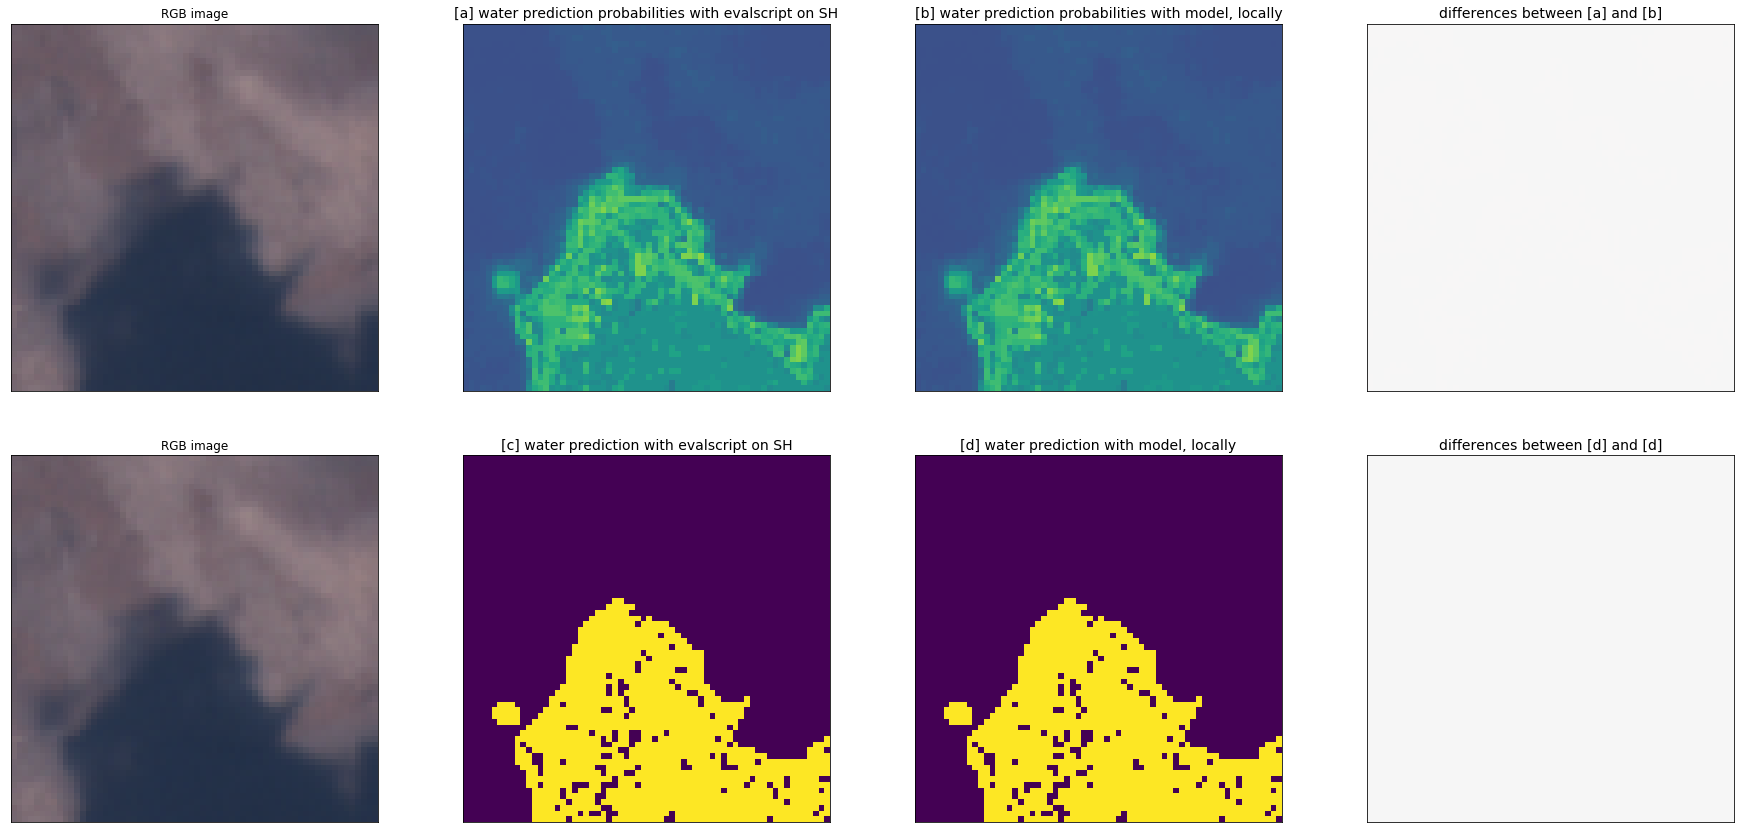

In [33]:
plot_comparison(features[..., [2, 1, 0]], sh_prediction, model_prediction)

As we can see, the predictions, run locally, and predictions, run on SH, produce the same results. \o/

For purpose of conciseness, one can plot comparison over any patch we have locally by running:

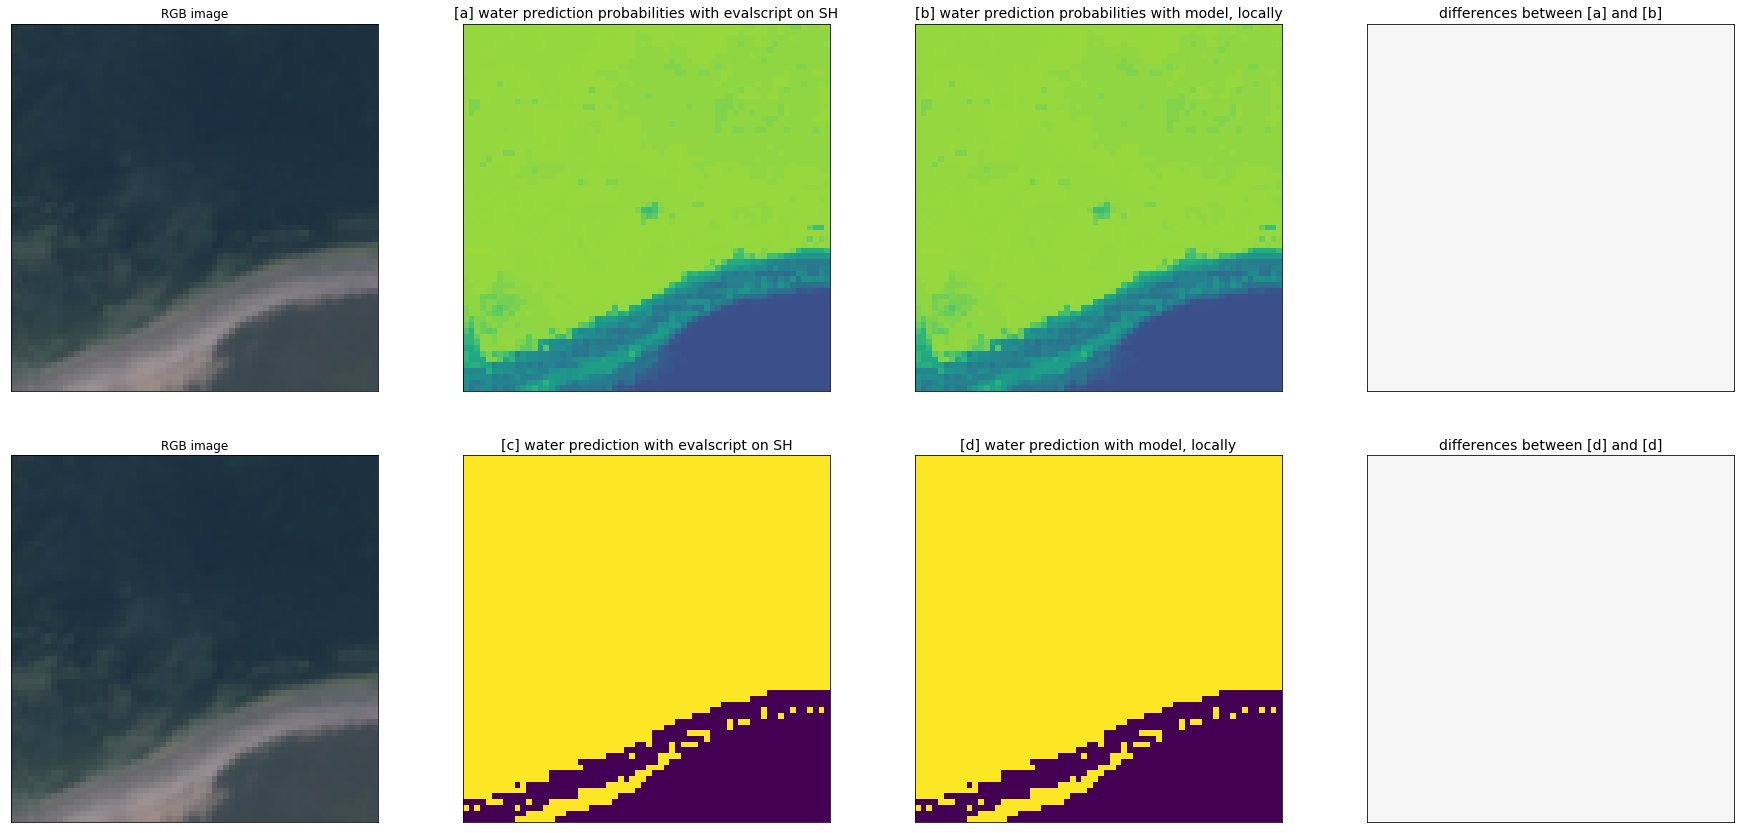

In [34]:
plot_comparison(*get_predictions(EOPatch.load(f'{EOP_DIR}/eopatches/{eopatch_names[1337]}'), model, config))

## Possible improvements

This notebook showcased a simple workflow to implement a ML-based workflow as a custom-script. 

Possible improvements for water-detection include:

 * use of DEM and S1 as input collections
 * optimise the model
 * replace the GBM algorithm with other pixel-wise [algorithms](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html), which can be ported to JavaScript using [this project](https://github.com/nok/sklearn-porter).